In [1]:
import sys, os
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), 'src'))

import src.testbed as testbed
from src.merge import BasesMerger

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Full model
Optimal transport full model

In [2]:
full_model, _ = testbed.run_case(config_path='data/opt_transport.xlsx', verbose=True)


Problem: 
- Name: x78625
  Lower bound: 918742871.6829451
  Upper bound: 918742871.6829451
  Number of objectives: 1
  Number of constraints: 104833
  Number of variables: 78625
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 78625
  Number of nonzeros: 209665
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.18899989128112793
  Error rc: 0
  Time: 1.452207088470459
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [3]:
df_full, df_full_hourly = testbed.export_solution(full_model, 'results/opt_transport')

In [4]:
df_full

,complete
of_value,9.187429e+08
thermal,2.351259e+06
renewable,1.227715e+06
nsp,1.716464e+05
1_to_2,0.000000e+00
1_to_3,0.000000e+00
2_to_1,2.748441e+06
2_to_3,0.000000e+00
3_to_1,8.305329e+05
3_to_2,3.971817e+05


Identification of bases after solving the full model

In [5]:
df_duals = testbed.export_duals(full_model, 'results/opt_transport')

In [6]:
df_bases = testbed.identify_bases(df_duals)

In [7]:
df_cf = pd.read_excel('data/opt_transport.xlsx', sheet_name='cap_factors')
df_cf.drop(columns='generator', inplace=True)

df_demand = pd.read_excel('data/opt_transport.xlsx', sheet_name='demand')

df_input = pd.merge(df_demand, df_cf, on='period')
df_input['period'] = df_input['period'].astype(str)

df_input = pd.merge(df_input, df_bases, on='period')

Visualization of $D_{1,t}$ and ${CF}_{Re,t}$ time series used by the full model

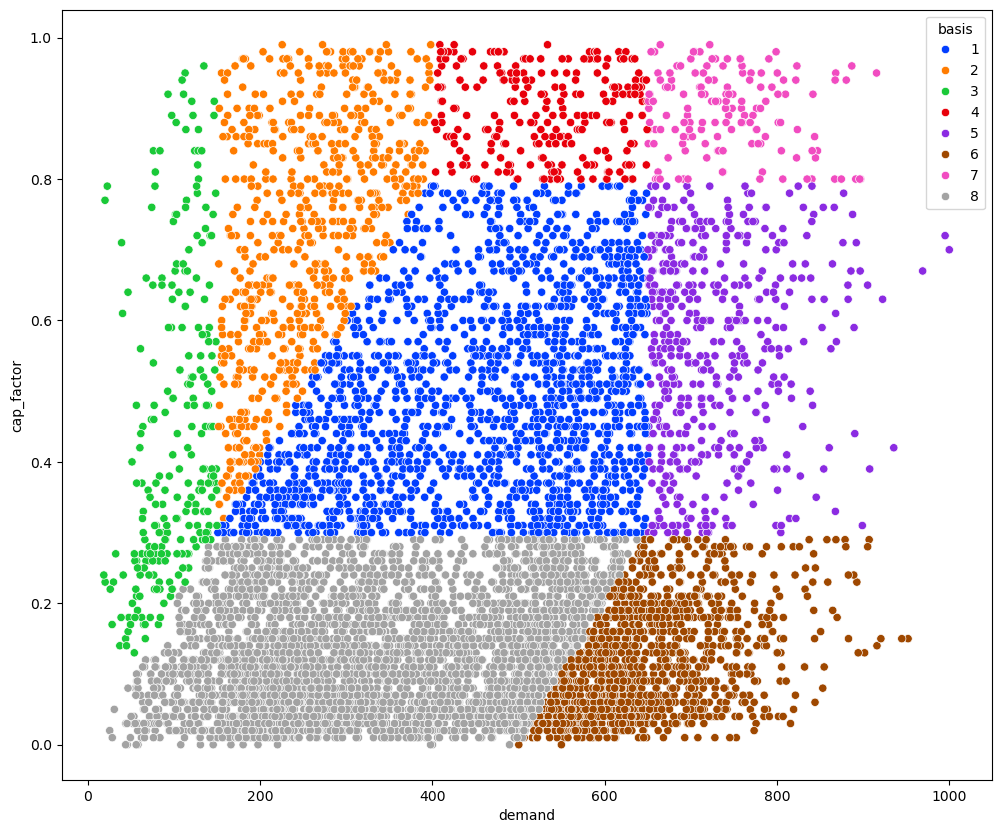

In [8]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_input, x='demand', y='cap_factor', hue='basis', palette='bright')
plt.show()

# Aggregated model

Computation of bases centroids $\bar b_i$

In [9]:
df_bases_centroids = df_input.groupby('basis').agg({'cap_factor': 'mean', 'demand': 'mean', 'basis': 'count'}).rename(columns={'basis':'weight'})
df_bases_centroids.reset_index(drop=False, inplace=True)
df_bases_centroids.columns = df_bases_centroids.columns.get_level_values(0)
df_bases_centroids = df_bases_centroids[['basis', 'cap_factor', 'demand', 'weight']]
df_bases_centroids

,basis,cap_factor,demand,weight
0,1,0.486833,454.242177,1768
1,2,0.717130,253.911291,669
2,3,0.443705,99.115016,251
3,4,0.893320,531.374428,247
4,5,0.555598,727.651920,493
5,6,0.111295,643.566720,1359
6,7,0.895099,741.932510,151
7,8,0.121553,336.007028,3798


Visualization of bases centroids $\bar b_i$

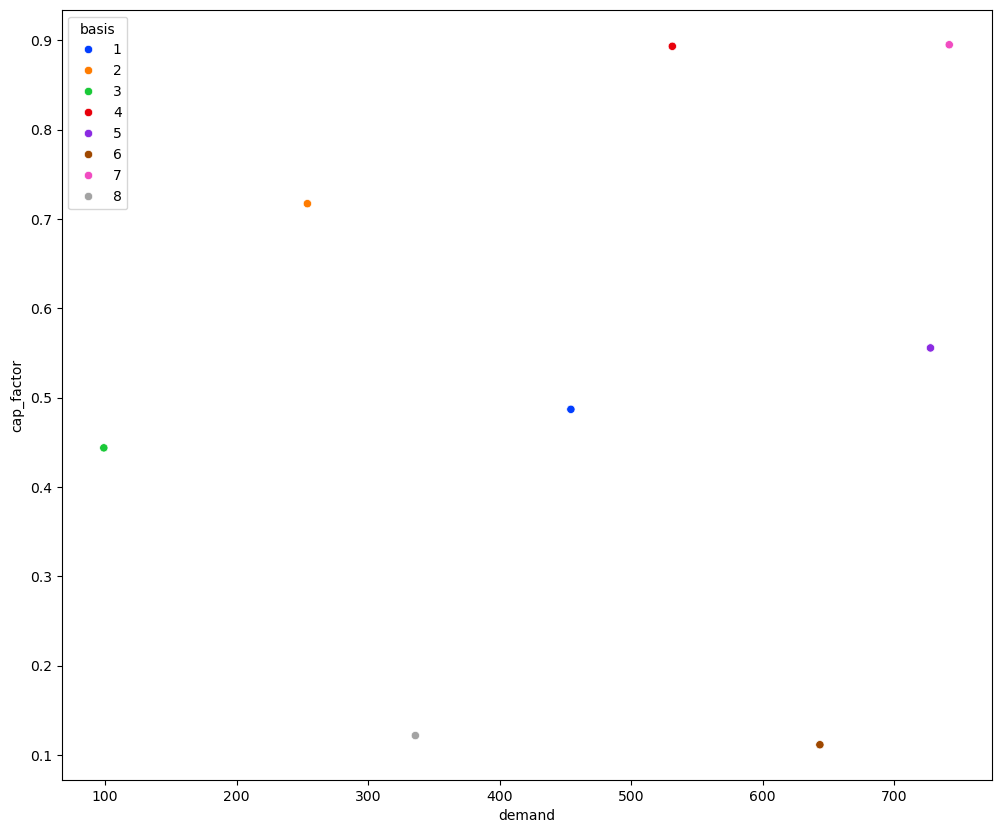

In [10]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_bases_centroids, x='demand', y='cap_factor', hue='basis', palette='bright')
plt.show()

Solving aggregated model using only bases centroids $\bar b_i$

In [11]:
df_agg_config, config_path = testbed.generate_agg_config('opt_transport.xlsx', df_bases_centroids)

In [12]:
agg_model, weights = testbed.run_case(config_path=config_path, verbose=True)


Problem: 
- Name: x73
  Lower bound: 918742871.6829438
  Upper bound: 918742871.6829438
  Number of objectives: 1
  Number of constraints: 97
  Number of variables: 73
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 73
  Number of nonzeros: 193
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.003000020980834961
  Error rc: 0
  Time: 0.14589476585388184
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [13]:
df_agg, df_agg_hourly = testbed.export_solution(agg_model, 'results/opt_transport_agg', weights=weights)

In [14]:
df_agg

,complete
of_value,9.187429e+08
thermal,2.351259e+06
renewable,1.227715e+06
nsp,1.716464e+05
1_to_2,0.000000e+00
1_to_3,0.000000e+00
2_to_1,2.748441e+06
2_to_3,0.000000e+00
3_to_1,8.305329e+05
3_to_2,3.971817e+05


Full and aggregated models produce same output (OFV and decision variables) on average

In [15]:
testbed.export_model_comparison(df_full, df_agg)

,complete,aggregated,delta,rel_delta
of_value,9.187429e+08,9.187429e+08,1.668930e-06,1.776357e-15
thermal,2.351259e+06,2.351259e+06,6.519258e-09,2.775558e-15
renewable,1.227715e+06,1.227715e+06,-6.984919e-10,-6.661338e-16
nsp,1.716464e+05,1.716464e+05,8.731149e-11,5.551115e-16
1_to_2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1_to_3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2_to_1,2.748441e+06,2.748441e+06,-1.024455e-08,-3.774758e-15
2_to_3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3_to_1,8.305329e+05,8.305329e+05,-2.328306e-10,-2.220446e-16
3_to_2,3.971817e+05,3.971817e+05,-5.238689e-10,-1.332268e-15


In [16]:
df_duals_agg = testbed.export_duals(agg_model, 'results/opt_transport_agg')

Duals from aggregated model

In [17]:
df_duals_agg

,period,eBalance_bus_1,eBalance_bus_2,eBalance_bus_3,eMaxProd_t1,eMaxProd_w1,eNSP,eMaxLim_1_exp,eMaxLim_1_imp,eMaxLim_2_exp,eMaxLim_2_imp,eMaxLim_3_exp,eMaxLim_3_imp
0,1,42608.8,42432.0,42255.2,0.0,-36951.2,0.0,0.0,0.0,0.0,0.0,-176.8,0.0
1,2,2140.8,2073.9,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-66.9,0.0
2,3,778.1,753.0,753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,5952.7,5928.0,741.0,0.0,0.0,0.0,0.0,0.0,0.0,-5162.3,-5187.0,0.0
4,5,2465000.0,11832.0,11782.7,0.0,-10303.7,0.0,0.0,-2453118.7,0.0,0.0,-2453168.0,0.0
5,6,6795000.0,6794728.2,6794864.1,-6762112.2,-6790787.1,0.0,0.0,-135.9,0.0,0.0,0.0,0.0
6,7,755000.0,3624.0,453.0,0.0,0.0,0.0,0.0,-751360.9,0.0,-3155.9,-754531.9,0.0
7,8,91531.8,91152.0,91152.0,0.0,-79758.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Bases merging
Merging of bases 2 and 3

In [18]:
basis_merger = BasesMerger(df_input[['period', 'demand', 'cap_factor']].copy(), df_bases)

Visualization of merging of bases 2 and 3. The aggregated model only considers the centroids, marked by black crosses.

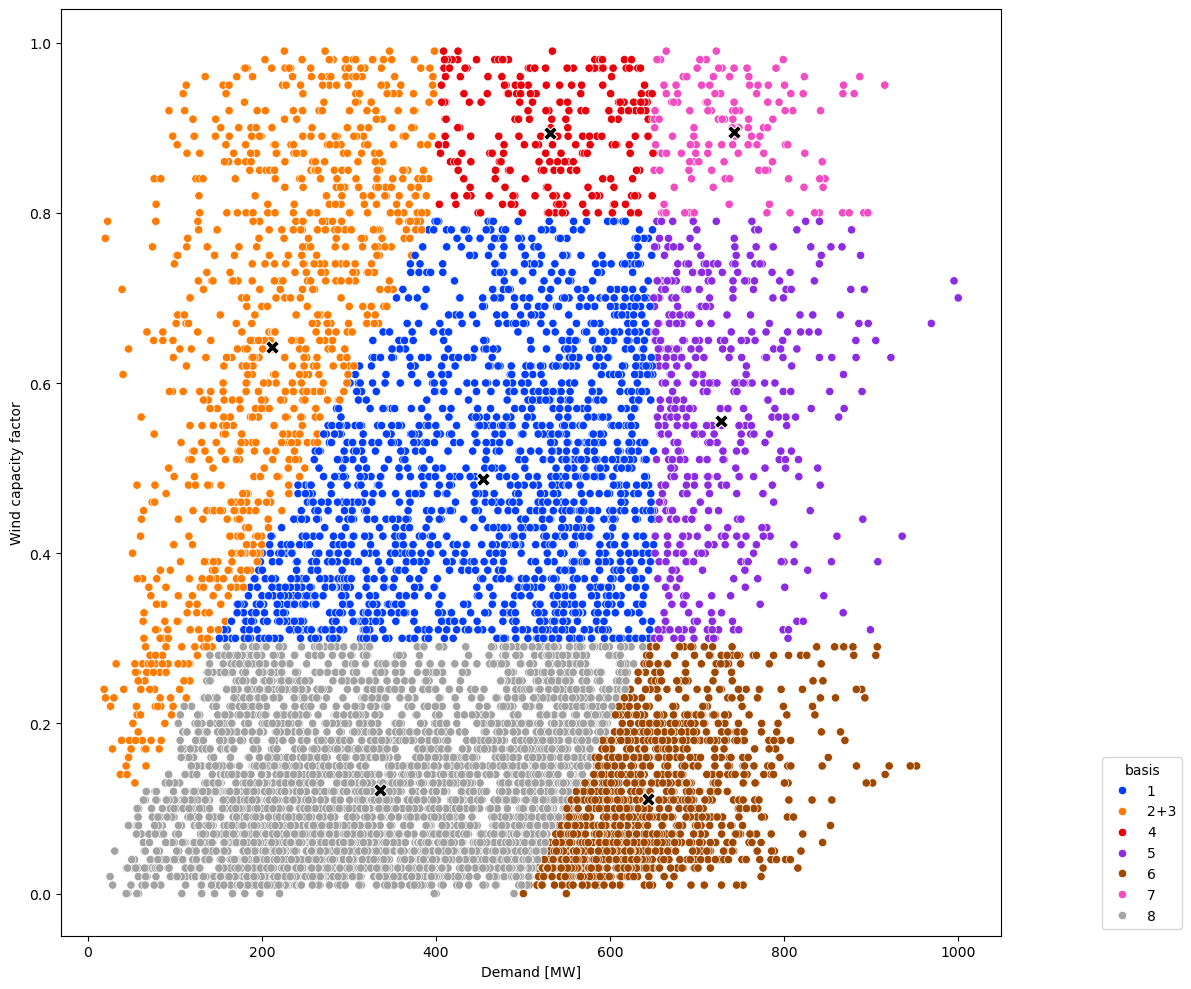

In [19]:
merger = [[1], [2, 3], [4], [5], [6], [7], [8]]

df_merge_config, df_merge_results, df_merge_hourly_results = basis_merger.merge(merger, plot_merge=True)

In [20]:
df_merge_results

,complete
of_value,9.187416e+08
thermal,2.351259e+06
renewable,1.227715e+06
nsp,1.716464e+05
1_to_2,0.000000e+00
1_to_3,0.000000e+00
2_to_1,2.735669e+06
2_to_3,0.000000e+00
3_to_1,8.433050e+05
3_to_2,3.844095e+05


The aggregated model corresponding to the merging of bases 2 and 3 incurs an error in approximating the OFV and decision variables w.r.t the full model (and exact aggregated model).

In [21]:
testbed.export_model_comparison(df_agg, df_merge_results)

,complete,aggregated,delta,rel_delta
of_value,9.187429e+08,9.187416e+08,1277.213107,0.000001
thermal,2.351259e+06,2.351259e+06,0.000000,0.000000
renewable,1.227715e+06,1.227715e+06,0.000000,0.000000
nsp,1.716464e+05,1.716464e+05,0.000000,0.000000
1_to_2,0.000000e+00,0.000000e+00,0.000000,0.000000
1_to_3,0.000000e+00,0.000000e+00,0.000000,0.000000
2_to_1,2.748441e+06,2.735669e+06,12772.131069,0.004647
2_to_3,0.000000e+00,0.000000e+00,0.000000,0.000000
3_to_1,8.305329e+05,8.433050e+05,-12772.131069,-0.015378
3_to_2,3.971817e+05,3.844095e+05,12772.131069,0.032157
